# Assignment-1
## Team: Aditya Ahuja (2020275), Deeptanshu Barman Chowdhuri (2020293)

##  Imports & Dataset

In [28]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu"


In [3]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [4]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
class_index_t10v_noise = list(Noise_Low_dataframe["target_10_val"].unique())

def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

def encode_noise_t10v(value, class_index = class_index_t10v_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["target_10_val"] = Noise_Low_dataframe["target_10_val"].apply(encode_noise_t10v)
Noise_High_dataframe["target_10_val"] = Noise_High_dataframe["target_10_val"].apply(encode_noise_t10v)

##  Cascade_Model

In [13]:
class MyMLP(torch.nn.Module):
    def __init__ (self, layers,activation = torch.nn.ReLU(), dropout = 0.5):
        super().__init__()
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.layers = []
        for i in range(len(linear)):
            if (i == len(linear)-1):
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)
                if (dropout!=0): self.layers.append(torch.nn.Dropout(dropout))
        self.layers = torch.nn.Sequential(*self.layers)
        self.temperature = torch.nn.Parameter(torch.ones(1))
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, X):          
        X = self.layers(X)
        X=X/torch.abs(self.temperature)
        X = self.softmax(X)
        return X

In [14]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [15]:
def expected_calibration_error(samples, true_labels, M=5):
    # uniform binning approach with M number of bins
    bin_boundaries = torch.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = torch.max(samples, dim=1)[0]
    # get predictions from confidences (positional in this case)
    predicted_label = torch.argmax(samples, dim=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label == true_labels

    ece = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = torch.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.float().mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].float().mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece.item()

In [37]:
def train_with_calibration(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            ece=expected_calibration_error(outputs,labels)
            loss = criterion(outputs, labels)+ece
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        if (val_loader != None):
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss = running_val_loss / len(val_loader)
            val_accuracy = correct_val / total_val
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    if (val_loader != None):
        plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
        plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
    
    else:
        plt.plot(range(1,num_epochs+1),train_accuracies,label='Train')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        

    plt.show()

In [213]:
def train_cascade(initial_data,initial_label,impurity,level,epochs=3):
    initial_data, initial_label = torch.from_numpy(initial_data).to(device), torch.from_numpy(initial_label).to(device)
    Dataset  = torch.utils.data.TensorDataset(initial_data, initial_label)
    D_loader = DataLoader(Dataset, batch_size=1024, shuffle=True)  
    Models =[]
    for lev in range(level):
        level_total_correct = 0
        level_total = 0
        print("Current Level:",lev)
        adaptive_layers = [24,64*(level+1),64*(level+1),5]
        level_model = MyMLP(layers = adaptive_layers, dropout=0).to(device)
        level_model = level_model.to(device)
        optimizer = torch.optim.Adam(level_model.parameters(), lr=0.004)
        train_with_calibration(level_model,torch.nn.NLLLoss(), optimizer,D_loader,None,num_epochs=epochs)
        new_dataset=[]
        new_labelset=[]
        for inputs,labels in D_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs = level_model(inputs)
            outputs = torch.exp(outputs)
            gini=outputs@outputs.T
            gini=torch.diag(gini)
            gini=1-gini
            for i in range(len(gini)):
                if gini[i]>impurity[lev]:
                    new_dataset.append(inputs[i].cpu().detach().numpy())
                    new_labelset.append(labels[i].cpu().detach().numpy())
                else:
                    _,pred = torch.max(outputs[i], 0)
                    if pred == labels[i]:
                        level_total_correct += 1
                    level_total += 1
        print("Level accuracy:",level_total_correct/level_total)
        print("Number of samples pruned:",level_total)
        print("For the next level, the number of samples is:",len(new_dataset))
        new_dataset, new_labelset = torch.from_numpy(np.array(new_dataset)), torch.from_numpy(np.array(new_labelset))
        new_dataset = torch.utils.data.TensorDataset(new_dataset, new_labelset)
        D_loader = DataLoader(new_dataset, batch_size=1024, shuffle=True)    
        Models.append(level_model)
    return Models

In [214]:
#sample 80% of the train data 
train_data = Noise_Low_dataframe 
train_data,test_data = train_test_split(train_data, test_size=0.2, random_state=42)

Current Level: 0


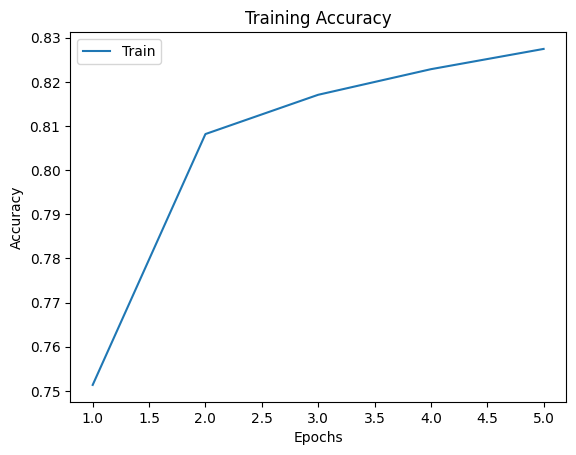

Level accuracy: 0.9948830571515191
Number of samples pruned: 135237
For the next level, the number of samples is: 114363
Current Level: 1


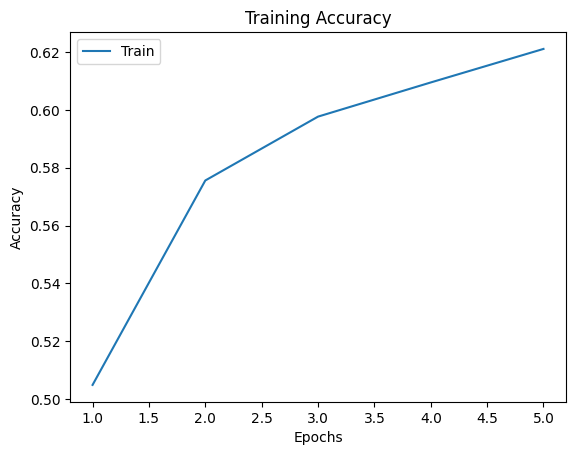

Level accuracy: 0.9040638779644857
Number of samples pruned: 16782
For the next level, the number of samples is: 97581
Current Level: 2


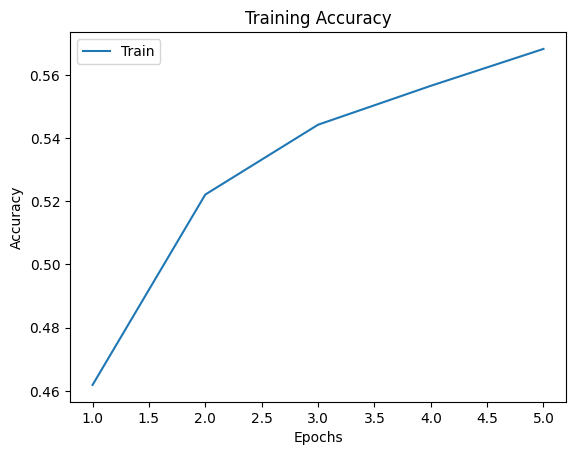

Level accuracy: 0.7196529522613065
Number of samples pruned: 25472
For the next level, the number of samples is: 72109
Current Level: 3


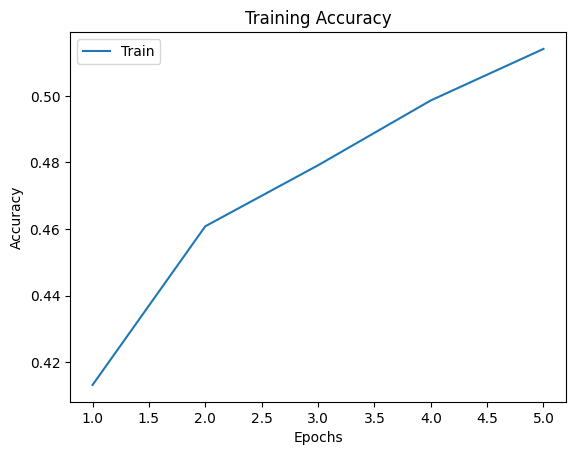

Level accuracy: 0.6739820964481663
Number of samples pruned: 3463
For the next level, the number of samples is: 68646


In [217]:
models = train_cascade(train_data.iloc[:,:-6].values,train_data.loc[:,"target_10_val"].values,level = 4, impurity = [0.1,0.3,0.5,0.5],epochs=5)

In [224]:
def test_cascade(models,initial_test_data,initial_test_labels,impurity):
    for model in models:
        model.eval()
    testloader = DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(initial_test_data).to(device), torch.from_numpy(initial_test_labels).to(device)), batch_size=1024, shuffle=True)
    total_correct = 0
    total_predicted = 0
    for modelnum in range(len(models)):
        correct_on_this_level = 0
        total_on_this_level = 0
        new_dataset=[]
        new_labelset=[]
        for inputs,labels in testloader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs = models[modelnum](inputs)
            outputs = torch.exp(outputs)
            gini = outputs@outputs.T
            gini = torch.diag(gini)
            gini = 1-gini
            for i in range(len(gini)):
                if gini[i]>impurity[modelnum]:
                    new_dataset.append(inputs[i].cpu().detach().numpy())
                    new_labelset.append(labels[i].cpu().detach().numpy())
                else:
                    pred = torch.argmax(outputs[i])
                    if (pred == labels[i]):
                        total_correct += 1
                        correct_on_this_level += 1
                    total_on_this_level += 1
                    total_predicted += 1
            
        if(total_on_this_level!=0): print("Accuracy at level-",modelnum,":",correct_on_this_level/total_on_this_level)
        new_dataset, new_labelset = torch.from_numpy(np.array(new_dataset)), torch.from_numpy(np.array(new_labelset))
        print("For this level, the number of samples is:",total_on_this_level)
        new_dataset = torch.utils.data.TensorDataset(new_dataset, new_labelset)
        if (len(new_dataset) == 0):
            break
        testloader = DataLoader(new_dataset, batch_size=1024, shuffle=True)
    print("TOTAL PREDCITED:",total_predicted)
    print("TOTAL NOT PREDICTED:",len(initial_test_data)-total_predicted)
    print("FINAL ACCURACY:",total_correct/total_predicted)

In [225]:
test_cascade(models,test_data.iloc[:,:-6].values,test_data.loc[:,"target_10_val"].values,impurity = [0.1,0.3,0.5,0.5])

Accuracy at level- 0 : 0.9935889825477858
For this level, the number of samples is: 33692
Accuracy at level- 1 : 0.9044433827042523
For this level, the number of samples is: 4186
Accuracy at level- 2 : 0.7133884803921569
For this level, the number of samples is: 6528
Accuracy at level- 3 : 0.6730083234244947
For this level, the number of samples is: 841
TOTAL PREDCITED: 45247
TOTAL NOT PREDICTED: 17153
FINAL ACCURACY: 0.9389572789356201
